In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))


In [2]:
import sys
sys.path.append('/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/')
import DCTR
import numpy as np
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from importlib import reload
reload(DCTR)


# load data

In [4]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0

X0_nrm = []
X1_nrm = []

# MiNNLO
X1_nrm = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/normed_lhe.npz'))
print('MiNNLO all particles X1.shape: '+str(X1_nrm.shape))

# POWHEG hvq
X0_nrm = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/normed_lhe.npz'))
print('POWHEG hvq all particles X0.shape: '+str(X0_nrm.shape))


MiNNLO all particles X1.shape: (9553938, 3, 9)
POWHEG hvq all particles X0.shape: (29605180, 3, 9)


In [24]:
# [pt, rapidity, phi, mass, pseudorapidity, E, PID, w, theta]
# [0 , 1       , 2  , 3   , 4             , 5, 6  , 7, 8    ]

# delete pseudorpaidity (eta) because it was giving me problems
X0_nrm = np.delete(X0_nrm, 4, -1)
X1_nrm = np.delete(X1_nrm, 4, -1)


In [6]:
# truncate the arrays to the length of the shorter one, so that both arrays have the same number of events

X0, X1 = DCTR.trim_datasets(X0_nrm.copy(), X1_nrm.copy())

print('POWHEG hvq all particles X0.shape: '+str(X0.shape))
print('MiNNLO all particles X1.shape: '+str(X1.shape))


POWHEG hvq all particles X0.shape: (9553938, 3, 9)
MiNNLO all particles X1.shape: (9553938, 3, 9)


# Neural Positive Reweighter

In [8]:
wgt_org = X1[:,0,6].copy() # would be arg 7, but we removed eta above


In [9]:
# neural positive reweigher for MiNNLO X1
from energyflow.utils import to_categorical
from sklearn.model_selection import train_test_split

x = np.concatenate([X1,X1]) # two identical copies
wgt = np.concatenate([wgt_org, np.ones(len(wgt_org))]) # wgts as is and all = 1 

y = np.concatenate([np.ones(len(X1)),np.zeros(len(X1))]) # identifier 
y = to_categorical(y, num_classes=2) # encode y as one hot

# split x, y, wgt into random training and validation datasets
X_rwgt_train, X_rwgt_val, Y_rwgt_train, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val = train_test_split(x[...,:-2], y, wgt, test_size=0.3) 

x = []
y = []
wgt = []


Starting training
Epoch 1/40
1630/1633 [============================>.] - ETA: 0s - loss: 0.6195 - acc: 0.4997
Epoch 1: val_loss improved from inf to 0.61646, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_X1_MiNNLO_positive_reweighing.h5
1633/1633 [==============================] - 10s 5ms/step - loss: 0.6195 - acc: 0.4997 - val_loss: 0.6165 - val_acc: 0.5001 - lr: 0.0010
Epoch 2/40
1628/1633 [============================>.] - ETA: 0s - loss: 0.6162 - acc: 0.4998
Epoch 2: val_loss improved from 0.61646 to 0.61611, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_X1_MiNNLO_positive_reweighing.h5
1633/1633 [==============================] - 8s 5ms/step - loss: 0.6162 - acc: 0.4998 - val_loss: 0.6161 - val_acc: 0.5001 - lr: 0.0010
Epoch 3/40
1629/1633 [============================>.] - ETA: 0s - loss: 0.6159 - acc: 0.4999
Epoch 3: val_loss improved from 0.61611 to 0.61577, saving model to /tf/home/gdrive/_STUDIUM_/Se

Restoring model weights from the end of the best epoch: 18.
1633/1633 [==============================] - 8s 5ms/step - loss: 0.6156 - acc: 0.4999 - val_loss: 0.6156 - val_acc: 0.5001 - lr: 8.2696e-04
Epoch 25: early stopping


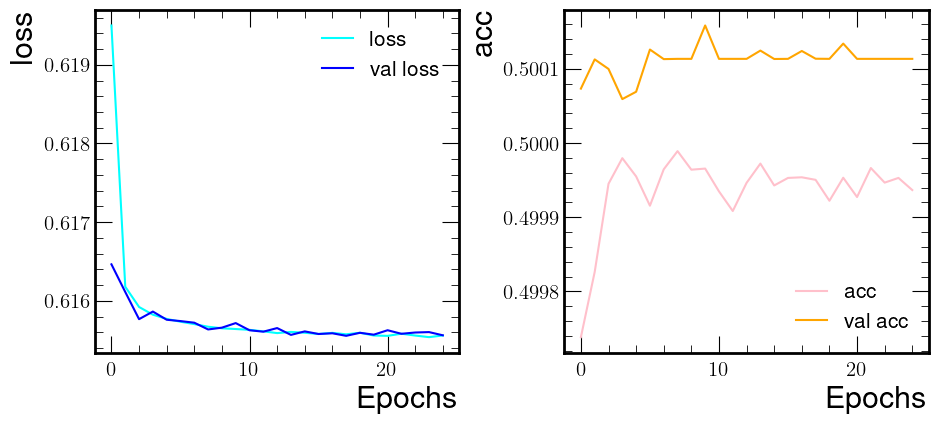

In [14]:
# train positive reweighing neural network

pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10)) # compiling model with different sizes clears weights

pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=7, saveLabel='DCTR_X1_MiNNLO_positive_reweighing')

DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, epochs=40, saveLabel='DCTR_X1_MiNNLO_positive_reweighing')


In [15]:
# load neural positive resampler training
pos_rwgt, _ = DCTR.setup_nn(input_dim=6)
pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing.h5') # trained previously

# make prediction 
with tf.device('/cpu:0'): # sometimes gave me errors when done on GPU
    rwgt_pred = pos_rwgt.predict(X1[...,:-2], batch_size = 4096, verbose=1) # without wgt and theta parameters, they are the last two parameters

# positive weights from predictions
wgt_pos = rwgt_pred[:,1] / rwgt_pred[:,0]

# adjust weights so that mean is 1, so that both datasets are equally important
wgt_pos /= np.mean(wgt_pos) 

print(np.mean(wgt_pos))



2333/2333 [==============================] - 10s 4ms/step
0.99999946


[ 1.  1.  1. ...  1. -1.  1.]
[1.1980978 1.2148682 1.1936406 ... 0.9911411 0.6321989 1.2162378]


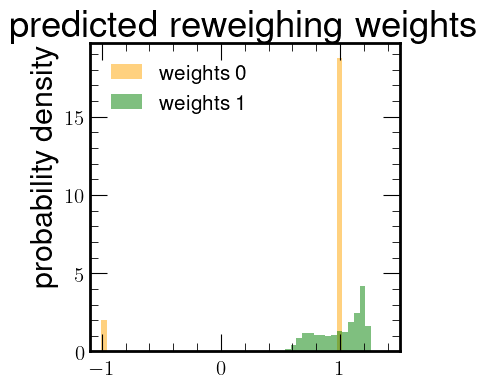

In [16]:
# give new positive weights to X1 MiNNLO dataset
X1[...,6] = wgt_pos[:, np.newaxis] # would be arg 7, but we removed eta above

print(wgt_org)
print(wgt_pos)

DCTR.plot_weights(wgt_org, wgt_pos, start=-1.1, stop=1.5, div=55)


In [14]:
# plot validation graphs

9435432out of 9553938 events (98.76%) are between $p_{T}$ [GeV] -3 and 3


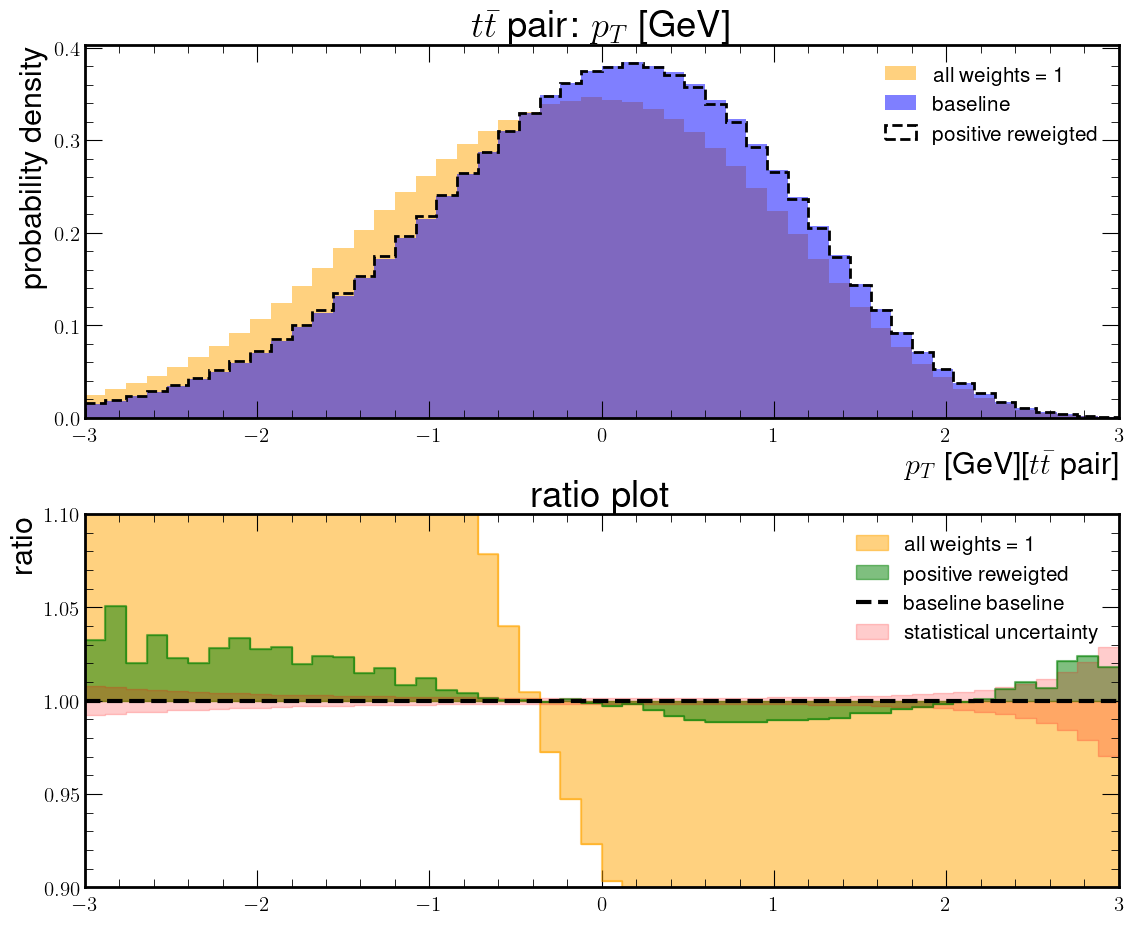

In [17]:
DCTR.plot_3_ratio(X1, X1, X1, arg_index = 0, part_index=0, start=-3, stop=3, div = 51, 
                  X0_wgt = 1, X1_wgt = wgt_org, X2_wgt = wgt_pos, X0_label = 'all weights = 1', X1_label = 'baseline', X2_label = 'positive reweigted')


9435432out of 9553938 events (98.76%) are between $p_{T}$ [GeV] -3 and 3


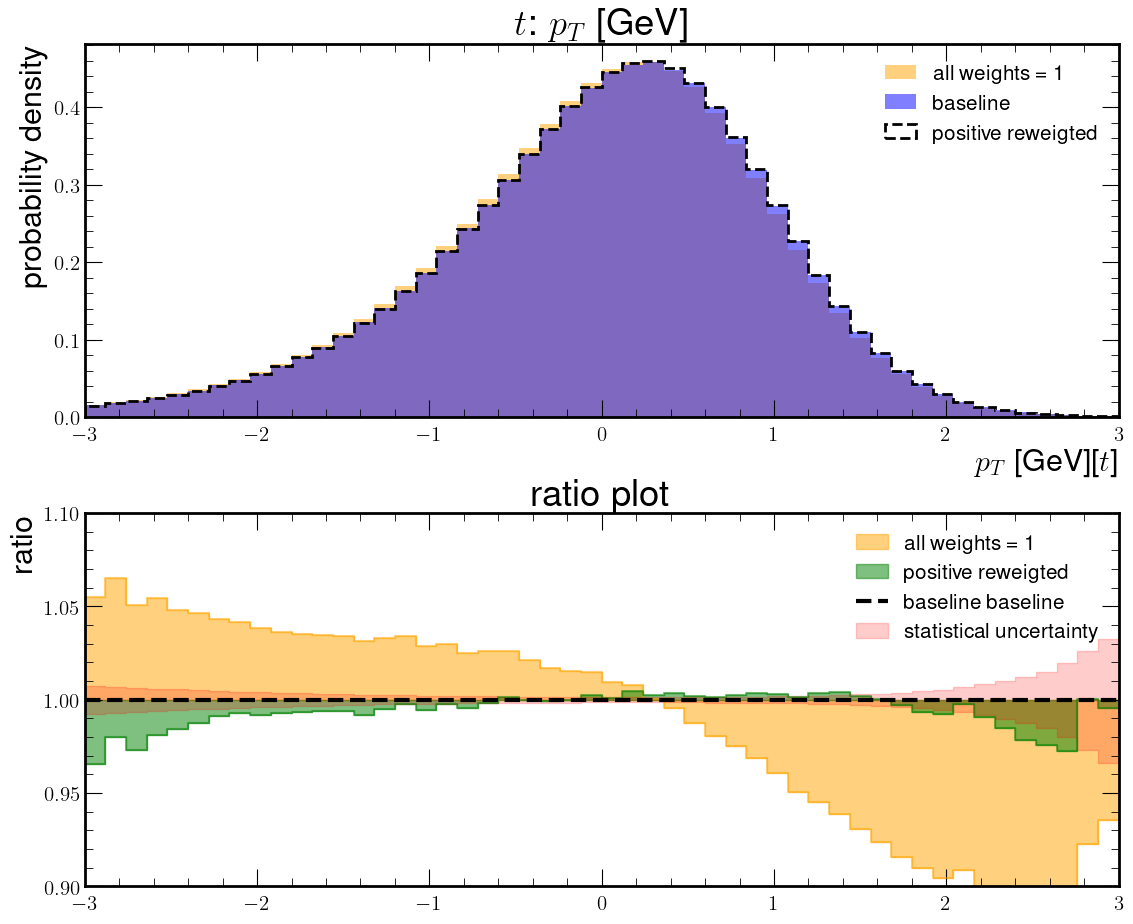

In [18]:
DCTR.plot_3_ratio(X1, X1, X1, arg_index = 0, part_index=1, start=-3, stop=3, div = 51, 
                  X0_wgt = 1, X1_wgt = wgt_org, X2_wgt = wgt_pos, X0_label = 'all weights = 1', X1_label = 'baseline', X2_label = 'positive reweigted')


# Preparing Datasets for Training

In [19]:
# prep arrays for the neural network
# Strips the theta parameter off the datasets and creates a one-hot classifier array Y
# Also strips the weights off the datasets and creates a weights array
# The Datasets are combined and returned shuffled (by default) 
# 15% (by default) are taken for the evaluation sets and the rest are used for the training
# returns: X_train, X_val, Y_train, Y_val, wgt_train, wgt_val

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0.copy(), X1.copy()) # defaults: val=0.15, shuffle=True, use_class_weights=False

# clear previous temp arrays from memory
# X0 = []
# X1 = []


In [20]:
wgt_train = np.abs(wgt_train)
wgt_val = np.abs(wgt_val)



# prep and train DCTR neural network

Starting training
Epoch 1/500
494/496 [============================>.] - ETA: 0s - loss: 0.6877 - acc: 0.5371
Epoch 1: val_loss improved from inf to 0.66756, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
496/496 [==============================] - 8s 14ms/step - loss: 0.6877 - acc: 0.5371 - val_loss: 0.6676 - val_acc: 0.5495 - lr: 0.0010
Epoch 2/500
494/496 [============================>.] - ETA: 0s - loss: 0.6658 - acc: 0.5518
Epoch 2: val_loss improved from 0.66756 to 0.66275, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
496/496 [==============================] - 7s 14ms/step - loss: 0.6658 - acc: 0.5518 - val_loss: 0.6627 - val_acc: 0.5505 - lr: 0.0010
Epoch 3/500
494/496 [============================>.] - ETA: 0s - loss: 0.6628 - acc: 0.5567
Epoch 3: val_loss improved from 0.66275 to 0.66152, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training

Epoch 27/500
495/496 [============================>.] - ETA: 0s - loss: 0.6599 - acc: 0.5591
Epoch 27: val_loss did not improve from 0.66005
496/496 [==============================] - 7s 14ms/step - loss: 0.6599 - acc: 0.5591 - val_loss: 0.6604 - val_acc: 0.5581 - lr: 7.9453e-04
Epoch 28/500
493/496 [============================>.] - ETA: 0s - loss: 0.6598 - acc: 0.5589
Epoch 28: val_loss did not improve from 0.66005
496/496 [==============================] - 7s 14ms/step - loss: 0.6598 - acc: 0.5589 - val_loss: 0.6603 - val_acc: 0.5581 - lr: 7.7880e-04
Epoch 29/500
495/496 [============================>.] - ETA: 0s - loss: 0.6599 - acc: 0.5590
Epoch 29: val_loss did not improve from 0.66005
496/496 [==============================] - 7s 14ms/step - loss: 0.6598 - acc: 0.5590 - val_loss: 0.6603 - val_acc: 0.5568 - lr: 7.6338e-04
Epoch 30/500
493/496 [============================>.] - ETA: 0s - loss: 0.6598 - acc: 0.5589
Epoch 30: val_loss did not improve from 0.66005
496/496 [==========

496/496 [==============================] - 7s 14ms/step - loss: 0.6595 - acc: 0.5598 - val_loss: 0.6600 - val_acc: 0.5601 - lr: 4.5384e-04
Epoch 55: early stopping


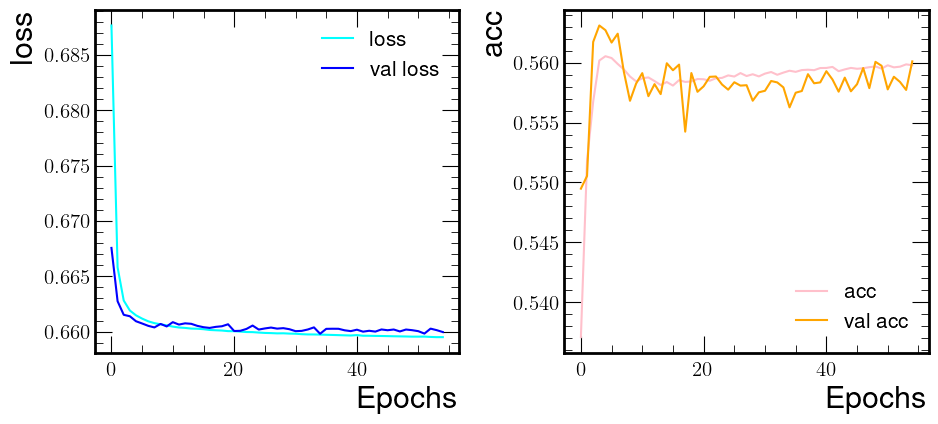

In [21]:
''' setup_nn() defaults
input_dim=7, Phi_sizes = (100,100,128), F_sizes = (100,100,100),
use_custom_loss=False, dropout=0.0, l2_reg=0.0, learning_rate=0.001,
patience=10, use_scheduler=True, use_focal=False, gamma=1.1,
monitor='val_loss', mode='min', savePath=currentPath,
saveLabel='DCTR_training', summary=False
'''
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,12), F_sizes = (10,10,10)) # compiling model with different sizes clears weights
                                
#initialize training
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.1, l2_reg=1e-7, patience=20)

# dctr.load_weights('DCTR_training.h5')
DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*4)


# verify DCTR predictions

In [22]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0
# all particles arrays

# POWHEG hvq
X0_test = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/converted_lhe.npz'))
X0_test = DCTR.remove_jet_parts(X0_test)

# MiNNLO
X1_test = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/converted_lhe.npz'))
X1_test = DCTR.remove_jet_parts(X1_test)

print('MiNNLO     X1_test.shape: '+str(X1_test.shape))
print('POWHEG hvq X0_test.shape: '+str(X0_test.shape))


MiNNLO     X1_test.shape: (9553938, 3, 9)
POWHEG hvq X0_test.shape: (29605180, 3, 9)


# load training and predict weights

In [ ]:
# load training
# dctr, callbacks = DCTR.setup_nn(input_dim = 6)
# dctr.load_weights('DCTR_training.h5')


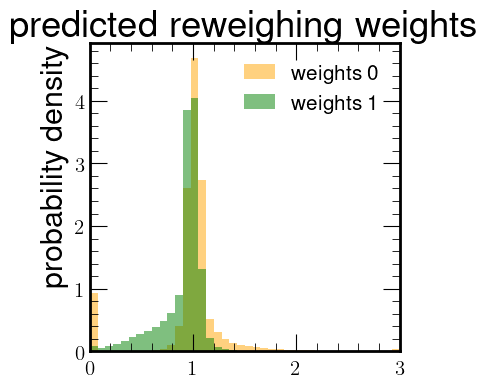

In [26]:
#plot weights
with tf.device('/cpu:0'): # sometimes gave me errors when done on GPU
    weights_0, weights_1 = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2])

DCTR.plot_weights(weights_0, weights_1, start=0, stop=3, div=41)


In [35]:
X0_nrm_wgt = X0_nrm[:, 0, 6] # would be arg 7, but we removed eta above
X1_nrm_wgt = X1_nrm[:, 0, 6]

print(X0_nrm_wgt)
print(X1_nrm_wgt)


[1.         1.         1.         ... 0.99930382 0.99930382 0.99930382]
[-1.  1. -1. ...  1.  1.  1.]


# check and plot DCTR predictions

In [36]:
# tt-pair

29458348out of 29605180 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


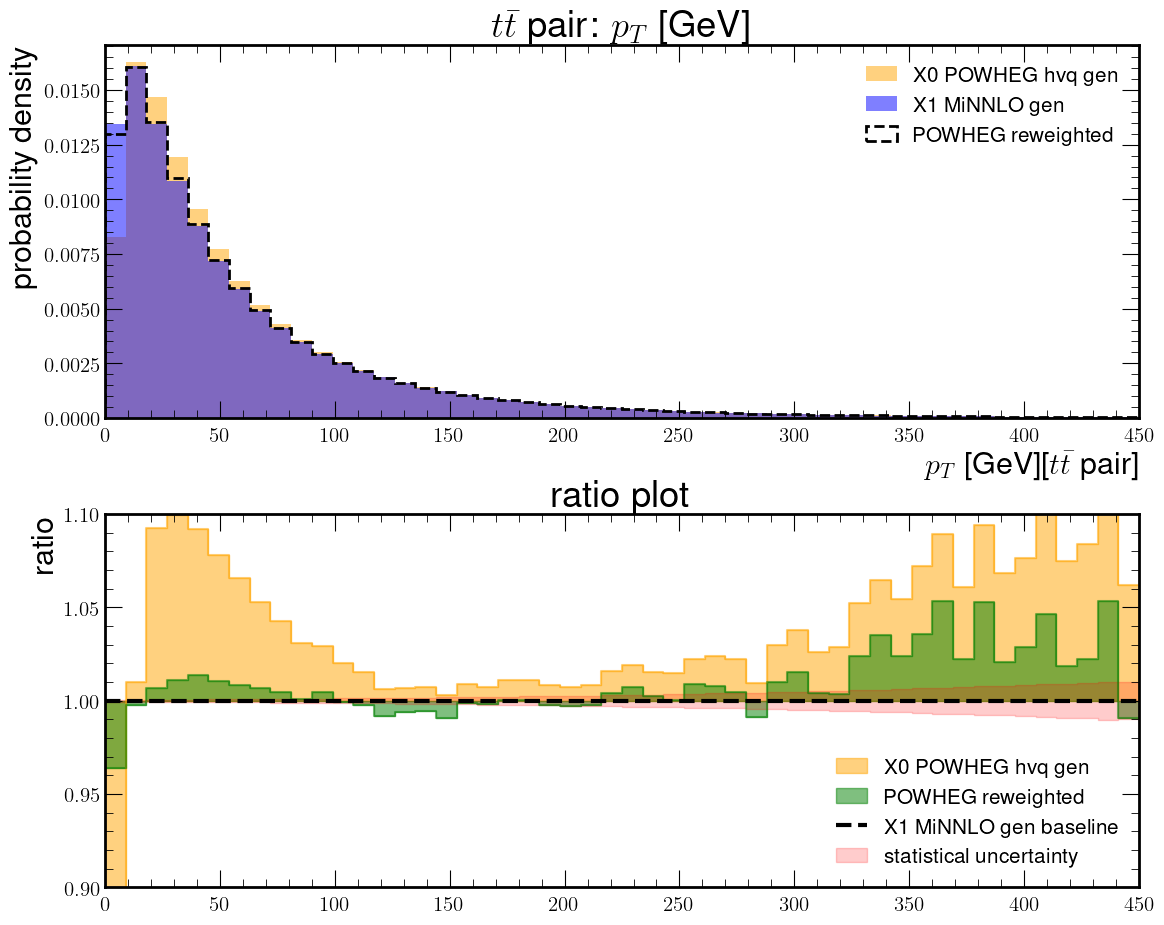

In [36]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, start=0, stop=450, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))

29253793out of 29605180 events (98.81%) are between mass [GeV] 300 and 1200


/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:917: RuntimeWarning: divide by zero encountered in true_divide
  ax2.step(bins, (n0/n1), alpha=0.5, color='orange', where='post')
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:918: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(bins, n0/n1, 1, label = X0_label, alpha=0.5, color='orange', step='post')
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:920: RuntimeWarning: divide by zero encountered in true_divide
  ax2.step(bins, (n2/n1), alpha=0.5, color='green', where='post')
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:921: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(bins, n2/n1, 1, label = X2_label, alpha=0.5, color='green', step='post')


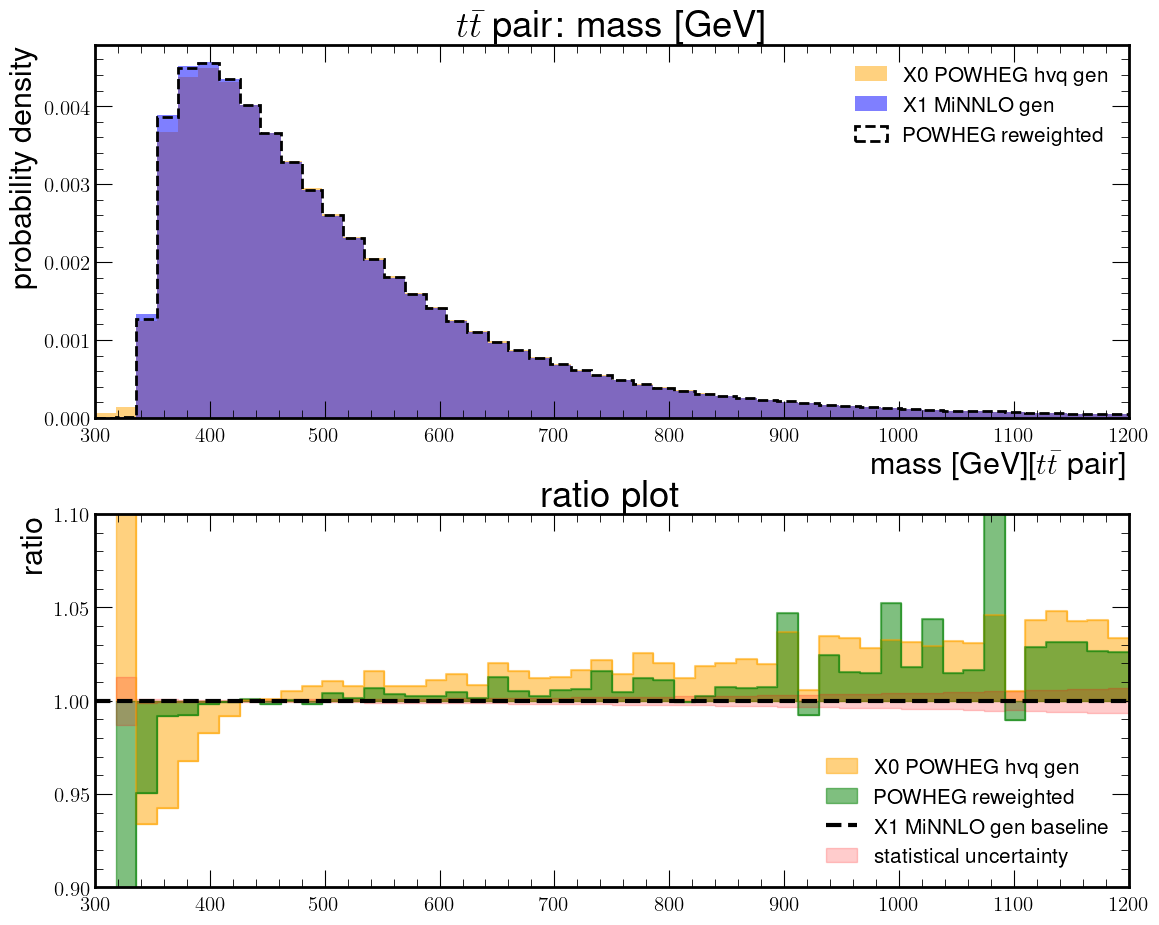

In [37]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, start=300, stop=1200, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


In [38]:
# top quark

29458348out of 29605180 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


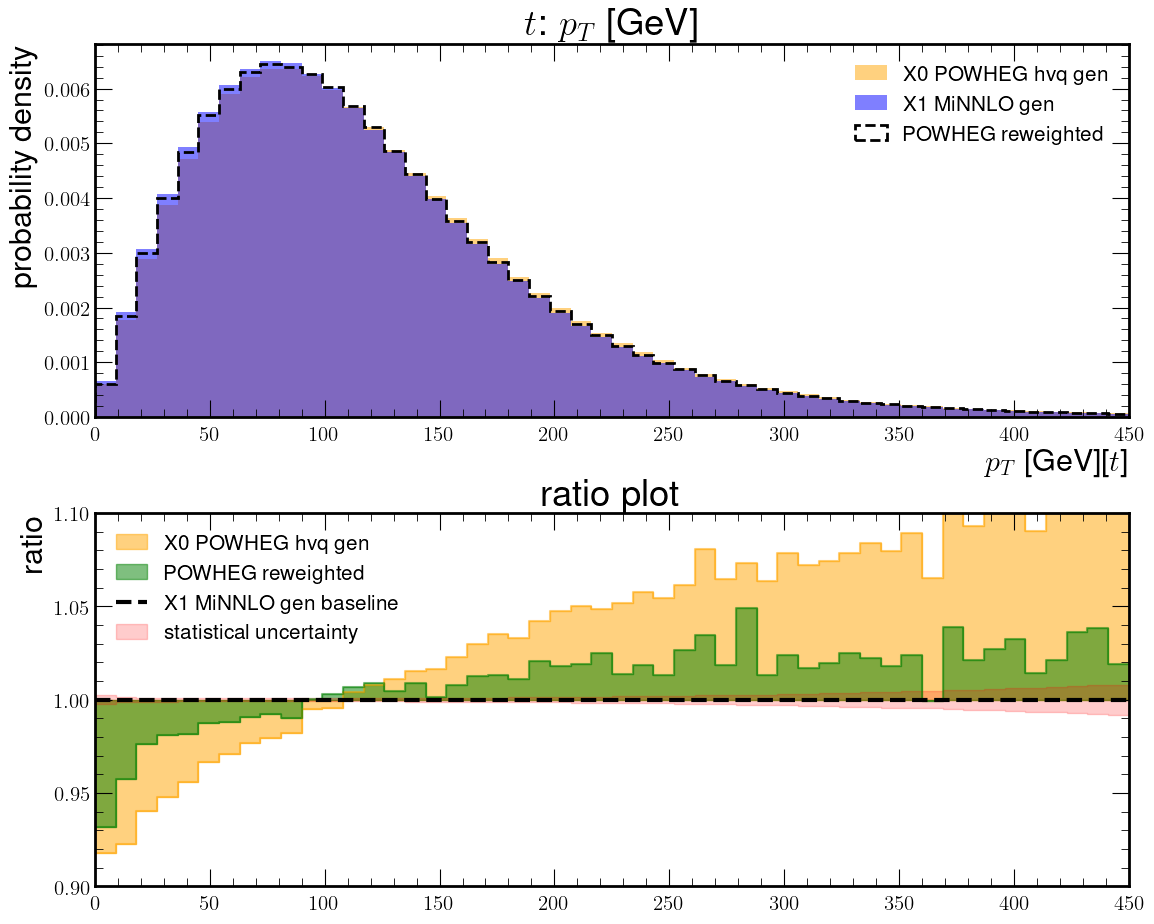

In [39]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, part_index = 1, start=0, stop=450, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


0out of 29605180 events (0.0%) are between mass [GeV] 160 and 180


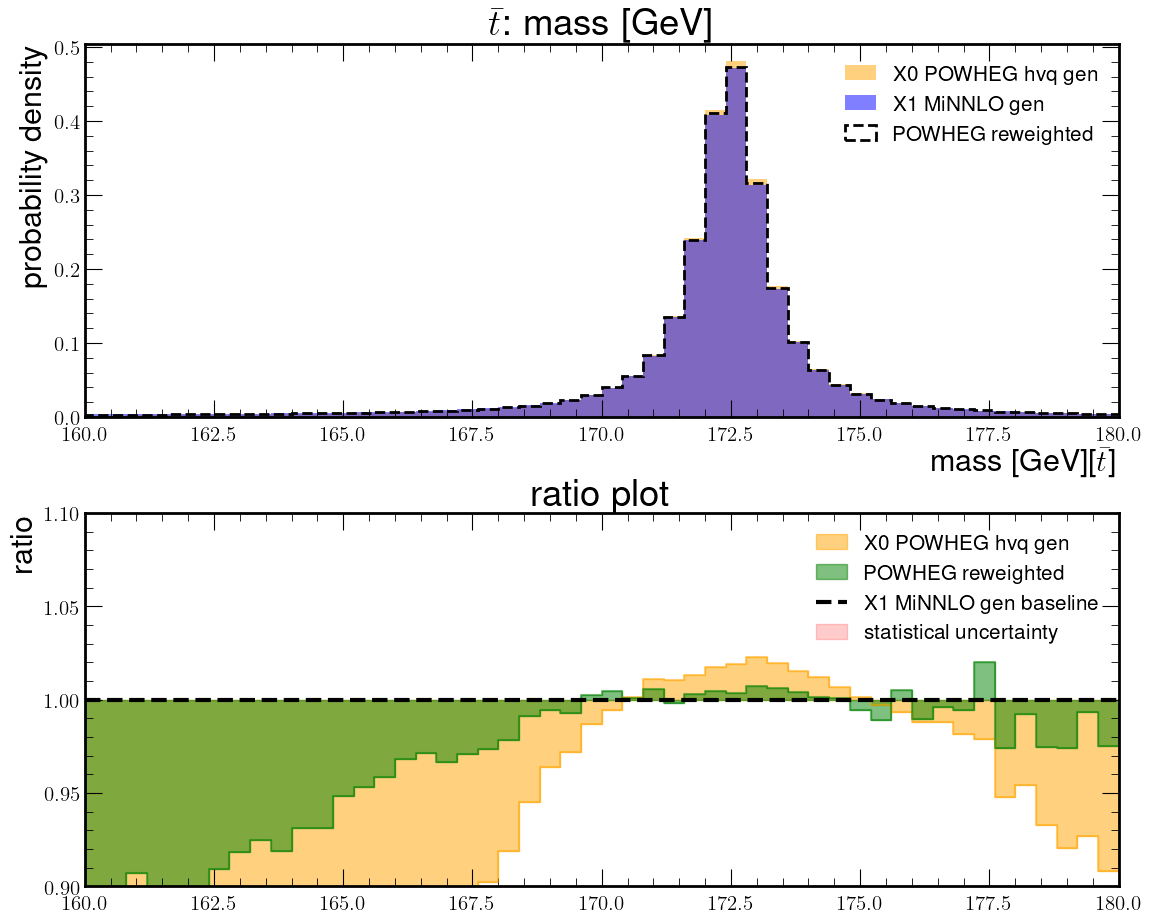

In [40]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, part_index = 2, start=160, stop=180, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


In [41]:
# anti-top

29458348out of 29605180 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


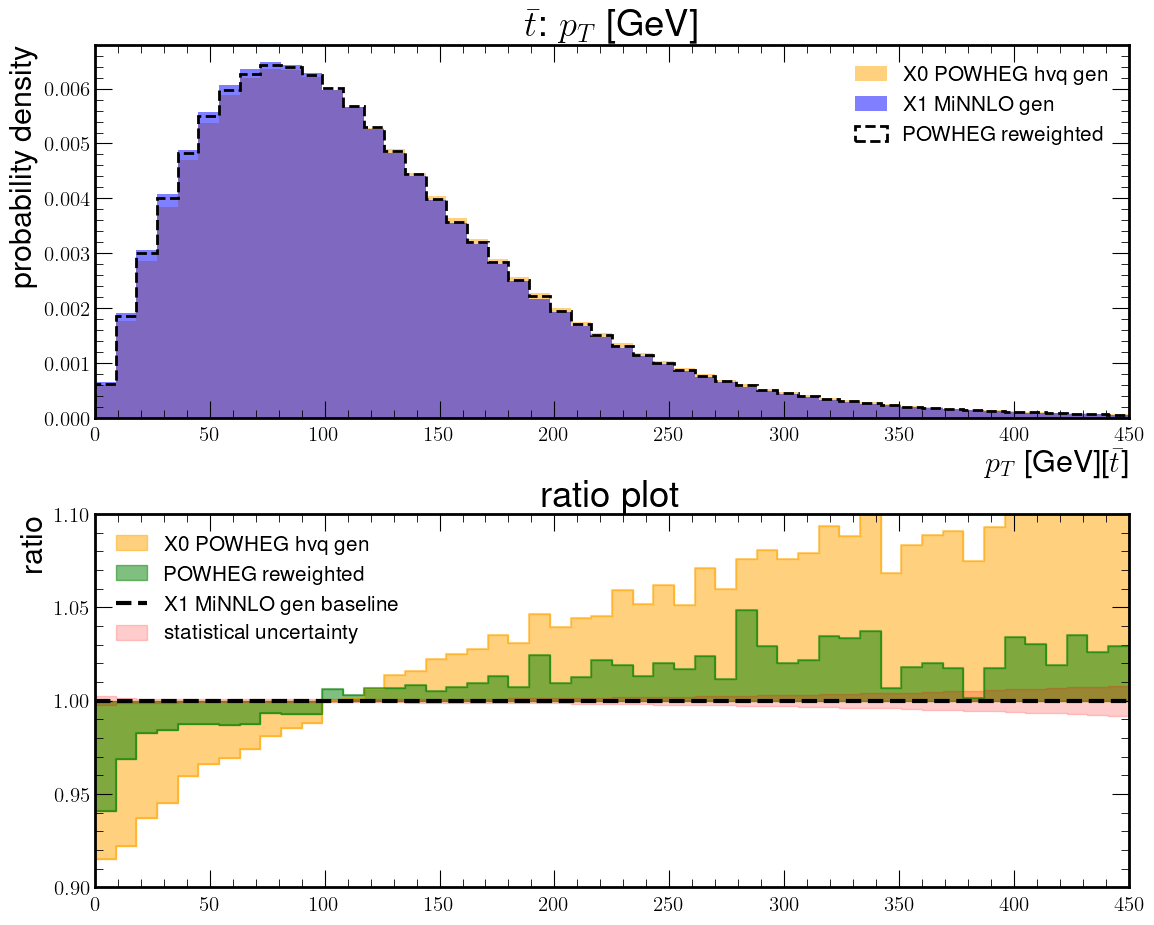

In [42]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, part_index = 2, start=0, stop=450, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


0out of 29605180 events (0.0%) are between mass [GeV] 160 and 180


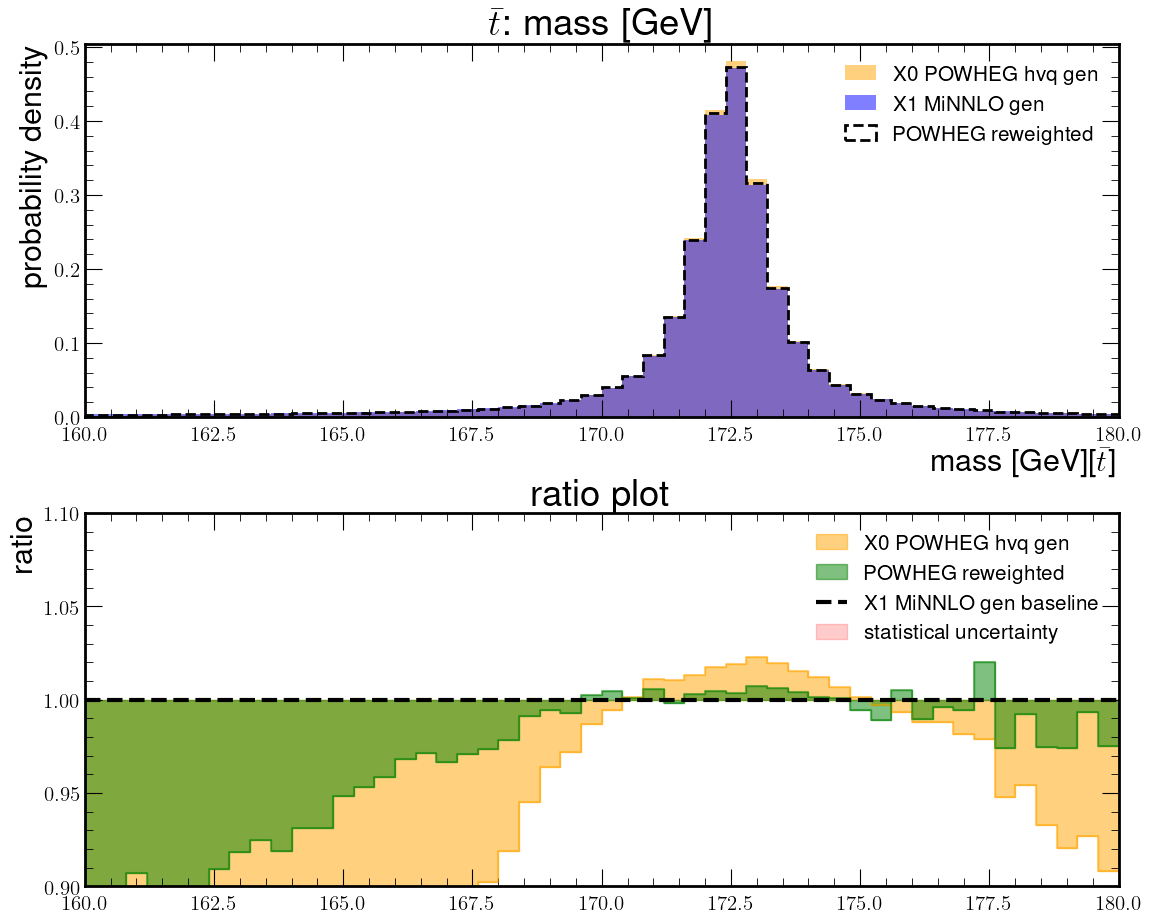

In [43]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, part_index = 2, start=160, stop=180, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))
